## MovieLen-100k data

## Initial setting for GGColab

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=b8d7c2f848338c4d3c446f4d51773f21e3f3ade57569cde307724986df128d0c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
%cd "/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als


In [ ]:
%pwd

"/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

## Preprocessing

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [ ]:
# Read data
spark = SparkSession.builder.appName("ALS rec sys").getOrCreate()
mv_rating = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)

mv_rating.show()


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
# Show random 5 rows:
mv_rating.sample(False, 0.1).show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   2150|   3.0|1260759194|
|     1|   2294|   2.0|1260759108|
|     2|     10|   4.0| 835355493|
|     2|     17|   5.0| 835355681|
|     2|    153|   4.0| 835355441|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
# Count how many customer in the dataframe
mv_rating.createOrReplaceTempView('movielen')
spark.sql("SELECT Count(distinct userId), Count(distinct movieId) from movielen").show()


+----------------------+-----------------------+
|count(DISTINCT userId)|count(DISTINCT movieId)|
+----------------------+-----------------------+
|                   671|                   9066|
+----------------------+-----------------------+



In [ ]:
# # Add random age and gender to each user:
# # age: random with range (18-50)
# # gender: random in list (0: female, 1: male)
# # --------------------------------------

# # get distinct userid:
# userids = spark.sql('select distinct userId from movielen').collect()
# userids = [u['userId'] for u in userids]
# print('user ids:', userids[:5])

# # create a random age and gender dataframe for each userids:
# random.seed(96)
# user_age_gender_random_list = \
#     [(u, random.randrange(18, 50), random.choice([0, 1])) for u in userids]
# print('user_age_gender_random_list', user_age_gender_random_list[:5])

# user_age_gender_random_df = spark.createDataFrame(
#     user_age_gender_random_list, 
#     ['userId', 'age', 'gender']
# )
# print('after random assigning age and gender:')
# user_age_gender_random_df.show(5)

# # merge to main df:
# mv_rating = mv_rating.join(
#     user_age_gender_random_df,
#     on = 'userId',
#     how = 'left'
# )

In [ ]:
# check null for all cols:
mv_rating.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in mv_rating.columns]
    ).show()

mv_rating.show(5)
mv_rating.printSchema()


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



## Train model:

In [ ]:
# Assigning global variables:
USER_COL = "userId"
ITEM_COL = "movieId"
RATING_COL = "rating"
PREDICT_COL = "prediction"
REC_QUANTITY = 5


In [ ]:
# train test split:
df_train, df_test = mv_rating.randomSplit([0.7, 0.3], seed = 96)

In [ ]:
# TRAIN MODEL WITH DEFAULT PARAMS:
#---------------------------------
als = ALS(
    userCol=    USER_COL, 
    itemCol=    ITEM_COL, 
    ratingCol=  RATING_COL, 
    coldStartStrategy="drop")

model = als.fit(df_train)

In [ ]:
# prediction on test dataset:
df_test_prd = model.transform(df_test)
df_test_prd.show()

+------+-------+------+----------+---+------+----------+
|userId|movieId|rating| timestamp|age|gender|prediction|
+------+-------+------+----------+---+------+----------+
|     1|     31|   2.5|1260759144| 36|     0|  2.331211|
|     1|   1129|   2.0|1260759185| 36|     0| 2.8302352|
|     1|   1287|   2.0|1260759187| 36|     0| 3.2167149|
|     1|   1293|   2.0|1260759148| 36|     0| 2.8833427|
|     1|   1343|   2.0|1260759131| 36|     0| 2.4378438|
|     1|   2968|   1.0|1260759200| 36|     0| 3.7492554|
|     2|     39|   5.0| 835355604| 27|     1| 2.8952727|
|     2|     50|   4.0| 835355586| 27|     1| 3.6414037|
|     2|    110|   4.0| 835355532| 27|     1| 3.7529802|
|     2|    153|   4.0| 835355441| 27|     1| 2.5824373|
|     2|    165|   3.0| 835355441| 27|     1|  2.878324|
|     2|    185|   3.0| 835355511| 27|     1| 3.0617256|
|     2|    235|   3.0| 835355664| 27|     1| 2.3823333|
|     2|    248|   3.0| 835355896| 27|     1| 2.9341023|
|     2|    265|   5.0| 8353556

In [ ]:
# Evalualtion:
#------------------------------------------
evaluations = SparkRatingEvaluation(
    df_test, 
    df_test_prd,
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_prediction=PREDICT_COL
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.9279849484836914


## Finetuning model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

### 1st time:

In [ ]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.001, 0.1, 1.0],
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.001},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1.0},
 {'rank': 30, 'regParam': 0.001},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 30, 'regParam': 1.0},
 {'rank': 40, 'regParam': 0.001},
 {'rank': 40, 'regParam': 0.1},
 {'rank': 40, 'regParam': 1.0}]

In [ ]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    
    evaluations = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(
    rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
    ) 

In [ ]:
rmse_score_array

array([[1.6007, 0.9224, 1.3324],
       [1.7095, 0.9225, 1.3324],
       [1.8756, 0.9207, 1.3324]])

In [ ]:
rmse_score

[1.6007, 0.9224, 1.3324, 1.7095, 0.9225, 1.3324, 1.8756, 0.9207, 1.3324]

<Axes: xlabel='reg. parameter', ylabel='rank'>

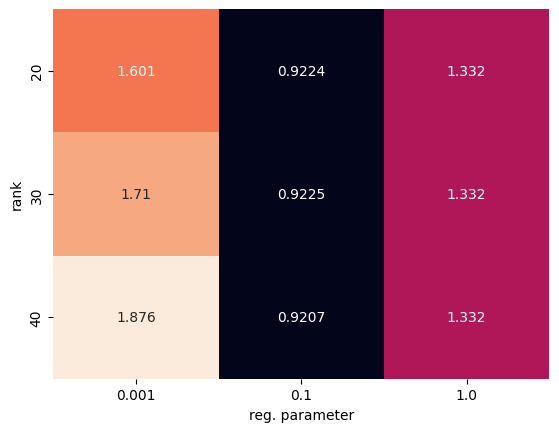

In [ ]:

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

with rank 40 and reg is 0.1 is the best one, let's try again

## Train model again with: regParam = 0.1, rank = 40

In [ ]:
als_fn = ALS(        
    userCol=USER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)

model = als_fn.fit(mv_rating)

## Top K Recommend for each customer

> Note: Need to ignore seen movies from each customer

In [ ]:
df_rec_user = model.recommendForAllUsers(REC_QUANTITY+20)

In [ ]:
df_rec_user.show(truncate = False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
+------+--

In [ ]:
# Expand recommendations:
df_rec_user_exp = df_rec_user.selectExpr(
    'userId', 'explode(recommendations) as recommendation'
    )
df_rec_user_exp.show()

+------+-------------------+
|userId|     recommendation|
+------+-------------------+
|     1| {73290, 3.5372164}|
|     1|  {1172, 3.4459722}|
|     1|{121231, 3.3520548}|
|     1|  {4101, 3.3138187}|
|     1|   {750, 3.2959025}|
|     1|   {326, 3.2870789}|
|     1|  {56367, 3.263873}|
|     1|   {926, 3.2507858}|
|     1|   {7669, 3.233566}|
|     1| {27741, 3.2317026}|
|     1|   {1235, 3.228352}|
|     1|  {26840, 3.220169}|
|     1|  {6413, 3.2189283}|
|     1|  {1953, 3.2188275}|
|     1|  {2105, 3.2160516}|
|     1| {88125, 3.2134273}|
|     1| {83411, 3.2069554}|
|     1| {83359, 3.2069554}|
|     1| {83318, 3.2069554}|
|     1| {67504, 3.2069554}|
+------+-------------------+
only showing top 20 rows



In [ ]:
df_rec_user_exp.select('recommendation').collect()[:5]

[Row(recommendation=Row(movieId=1235, rating=3.384129524230957)),
 Row(recommendation=Row(movieId=920, rating=3.383903980255127)),
 Row(recommendation=Row(movieId=2563, rating=3.381404161453247)),
 Row(recommendation=Row(movieId=121231, rating=3.378249406814575)),
 Row(recommendation=Row(movieId=1172, rating=3.3735275268554688))]

In [ ]:
# Get movieId from recommendation:
df_rec_user_exp = df_rec_user_exp.selectExpr(
    'userId',
    'recommendation.movieId as rec_movieId'
)
df_rec_user_exp.show()

+------+-----------+
|userId|rec_movieId|
+------+-----------+
|     1|      73290|
|     1|       1172|
|     1|     121231|
|     1|       4101|
|     1|        750|
|     1|        326|
|     1|      56367|
|     1|        926|
|     1|       7669|
|     1|      27741|
|     1|       1235|
|     1|      26840|
|     1|       6413|
|     1|       1953|
|     1|       2105|
|     1|      88125|
|     1|      83411|
|     1|      83359|
|     1|      83318|
|     1|      67504|
+------+-----------+
only showing top 20 rows



In [ ]:
mv_rating.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
# Excluding movies that user already rated:
df_rec_user_exp.join(
    mv_rating,
    [
        df_rec_user_exp.rec_movieId == mv_rating.movieId, 
        df_rec_user_exp.userId == mv_rating.userId
    ],
    how = 'left_anti',
).show()

+------+-----------+
|userId|rec_movieId|
+------+-----------+
|     1|      73290|
|     1|     121231|
|     1|       4101|
|     1|        750|
|     1|        326|
|     1|      56367|
|     1|        926|
|     1|       7669|
|     1|      27741|
|     1|       1235|
|     1|      26840|
|     1|       6413|
|     1|      88125|
|     1|      83411|
|     1|      83359|
|     1|      83318|
|     1|      67504|
|     1|       2810|
|     1|       1066|
|     1|        920|
+------+-----------+
only showing top 20 rows



In [ ]:
def get_user_rated_movies(user_ratings, threshold=4, userId=1):
    """
    Get a list of movies with above specified rating threshold from user ratings and specific user.

    Args:
        user_ratings (DataFrame): DataFrame containing user ratings.
        threshold (int, optional): Rating threshold. Defaults to 4.

    Returns:
        list: List of movie IDs with the specified rating.
    """
    # Filter user ratings based on the threshold
    filtered_ratings = user_ratings.where((col("rating") >= threshold) & (col('userId') == userId))

    # Get the list of movie IDs
    movie_ids = filtered_ratings.select("movieId").distinct().rdd.flatMap(lambda x: x).collect()

    return movie_ids

get_user_rated_movies(mv_rating, 4, 1)

[1172, 2105, 1953]

### Get movie names:

In [ ]:
df_mv = spark.read.csv('data/movies.csv', header = True)
df_mv.show(truncate = False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [ ]:
# Get rec movie names, genres
df_rec_user_exp.alias('df1').join(
    df_mv.alias('df2'),
    on = expr('df1.rec_movieId = df2.movieId'),
    how = 'left'
)\
    .groupBy('userId')\
    .agg(
        collect_list('rec_movieId').alias('rec_movieId'),
        collect_list('title').alias('rec_movieName'),
        collect_list('genres').alias('rec_genres') 
    )\
    .show(truncate = False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def get_user_rated_movies(
    mv_rating, 
    df_mv,
    threshold: int = 4, 
    userId: int = 1,
    top: int = 10
    ):
    """
    Get a list of movies with above specified rating threshold from user ratings and specific user.

    Args:
        mv_rating: DataFrame containing user ratings.
        df_mv: dataframe containing movie name
        threshold: int = 4: Rating threshold. Defaults to 4.
        userId: int = 1: userId, defauts to 1
        top: number of top movies will show

    Returns:
        list: List of movie IDs with the specified rating.
    """
    # Filter user ratings based on the threshold
    mv_rating.where((col("rating") >= threshold) & (col('userId') == userId))\
        .alias('df1')\
        .join(
            df_mv.alias('df2'),
            expr('df1.movieId = df2.movieId'),
            how = 'left'
        )\
        .selectExpr('df1.*', 'title', 'genres')\
        .sort(col('rating').desc())\
        .show(top, truncate = False)

get_user_rated_movies(mv_rating,df_mv, 4, 3)

+------+-------+------+----------+--------------------------------+---------------------------------------+
|userId|movieId|rating|timestamp |title                           |genres                                 |
+------+-------+------+----------+--------------------------------+---------------------------------------+
|3     |318    |5.0   |1298862121|Shawshank Redemption, The (1994)|Crime|Drama                            |
|3     |356    |5.0   |1298862167|Forrest Gump (1994)             |Comedy|Drama|Romance|War               |
|3     |1197   |5.0   |1298932770|Princess Bride, The (1987)      |Action|Adventure|Comedy|Fantasy|Romance|
|3     |2959   |5.0   |1298862874|Fight Club (1999)               |Action|Crime|Drama|Thriller            |
|3     |3949   |5.0   |1298863174|Requiem for a Dream (2000)      |Drama                                  |
|3     |296    |4.5   |1298862418|Pulp Fiction (1994)             |Comedy|Crime|Drama|Thriller            |
|3     |1721   |4.5   |12989

In [ ]:
# Get rec movie names, genres
df_rec_user_exp.filter(col('userId') == 3).alias('df1').join(
    df_mv.alias('df2'),
    on = expr('df1.rec_movieId = df2.movieId'),
    how = 'left'
).show(truncate = False)


+------+-----------+-------+-----------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|userId|rec_movieId|movieId|title                                                                                                                  |genres                                  |
+------+-----------+-------+-----------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|3     |83411      |83411  |Cops (1922)                                                                                                            |Comedy                                  |
|3     |83359      |83359  |Play House, The (1921)                                                                                                 |Comedy                                  |
|3     |83318      |83318  |Goat, The (1921)      